## Motivation {.unnumbered}


Similar to flow cytometry, a common issue with droplet-based single cell sequencing is the capture of multiple cells in a single droplet. The rate of doublet formation depends on the sequencing platform and the number of cells loaded. Below is a reference of doublet detection rate depending on no. of cells loaded during single-cell sequencing with the 10X chromium platform.

![10x Sequencing Doublet Detection Rate](https://kb.10xgenomics.com/hc/article_attachments/360086768291)

Removing doublets is an important step in single-cell analysis to prevent false-positive findings. In the previous chapter, cell multiplexing with hashtag oligo is an effective method to identify and remove <b>homolytic and heterolytic</b> "Doublets", however this requires sequencing of hashtag library which could be costly.

To overcome this issue there currently exists a few methods to identify "Doublets" based on mRNA expression, including DoubletFinder [[McGinnis et al.; 2019]](https://www.sciencedirect.com/science/article/pii/S2405471219300730?via%3Dihub), scDblFinder [[Germain et al, 2022]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9204188/), Scrublet [[Wolock et al.; 2019]](https://www.sciencedirect.com/science/article/pii/S2405471218304745) etc. Many of these algorithms require users to process and cluster the cells prior to doublet prediction, as the identification process typically involves comparing the expressions from each cell to the pseudobulk expression profile of each cluster. These algorithms are effective in predicting <b>heterolytic</b> doublets, as detection works best when the pseudobulk profiles of the clusters are massively different. The pitfall, however, is that when you have a homogenous samples (i.e. FACS-sorted B-/Plasma cells) comprised of <b>homolytic</b> doublets, these detection algorithms may not generate accurate doublet predictions as the pseudobulk profiles of each cluster are similar.

> In our case, our data consist of innate and adaptive immune cells where gene expressions of the major lineages are very different. We will therefore predict doublets using DoubletFinder and scDblFinder to see if it provides addition benefit to remove potential heterolytic doublets. Refering to the table above, each of the samples have ~8k cells captured, therefore doublet rate is 6.4%.

In [2]:
## set up environment
suppressMessages({
library(scUnify)
setwd("/nemo/lab/caladod/working/Matthew/project/matthew/MH_GSE247917")})

## load seurat objects
obj <- qread("seurat/1_processing/1.5_GSE247917_clustering.qs")
DefaultAssay(obj) <- "RNA"

Warning message:
“replacing previous import ‘cowplot::get_legend’ by ‘ggpubr::get_legend’ when loading ‘scUnify’”
Warning message:
“replacing previous import ‘cowplot::align_plots’ by ‘patchwork::align_plots’ when loading ‘scUnify’”
Warning message:
“replacing previous import ‘biomaRt::select’ by ‘rstatix::select’ when loading ‘scUnify’”
Warning message:
“replacing previous import ‘scales::viridis_pal’ by ‘viridis::viridis_pal’ when loading ‘scUnify’”


## Run scDblFinder
We will first perform doublet detection with scDblFinder with the wrapper function below. The function will convert Seurat to SingleCellExperiment (SCE) object, run scDblFinder pipeline, and return a Seurat object with scDblFinder outputs stored in Seurat metadata. User can also specify cell demultiplexing results in the \<truth\> argument where the function will input "Singlet" and "Doublet" cells solely for doublet detection.

:::{.callout-warning}
In the case where only certain samples have cell multiplex libraries, users will need to set any "NA" values to "Singlets" for the wrapper function to run properly.
:::

> In the run_scdblfinder() function, we specified cluster labels ("seurat_clusters"), sequencing runs ("samples"), doublet detection rate of 6.4% (dbr) and truth ("MULTI.global"). 

In [2]:
obj.list <- SplitObject(obj, split.by = "samples")

In [5]:
## convert to sce and run scDblFinder
for(i in seq_along(obj.list)){
    dbr <- calculate_10x_dbr(ncol(obj.list[[i]]))
    obj.list[[i]] <- run_scdblfinder(
        obj.list[[i]], 
        clusters = "integrated_snn_res.0.2", 
        samples = "samples", truth = "MULTI.global", 
        dbr=dbr, ncores = 30)}

returning assays (BCR, TCR) to RNA assay

Warning message:
“Different cells and/or features from existing assay RNA”
Warning message:
“Different cells and/or features from existing assay RNA”
Warning message:
“No layers found matching search pattern provided”
Warning message:
“No layers found matching search pattern provided”
Warning message:
“Layer ‘scale.data’ is empty”
Warning message:
“Assay RNA changing from Assay5 to Assay”
returning assays (BCR, TCR) to RNA assay

Warning message:
“Different cells and/or features from existing assay RNA”
Warning message:
“Different cells and/or features from existing assay RNA”
Warning message:
“No layers found matching search pattern provided”
Warning message:
“No layers found matching search pattern provided”
Warning message:
“Layer ‘scale.data’ is empty”
Warning message:
“Assay RNA changing from Assay5 to Assay”
R_zmq_msg_send errno: 4 strerror: Interrupted system call




Below we visualize the outputs of scDblFinder with MULTIseqDemux cell demultiplexing outputs and known characteristics of doublets (high nCount_RNA/HTO).

In [6]:
obj <- merge(obj.list[[1]], obj.list[2:length(obj.list)], merge.dr = T)

Merging reduction ‘pca’
Merging reduction ‘umap’


In [7]:
obj <- join_layers(obj)

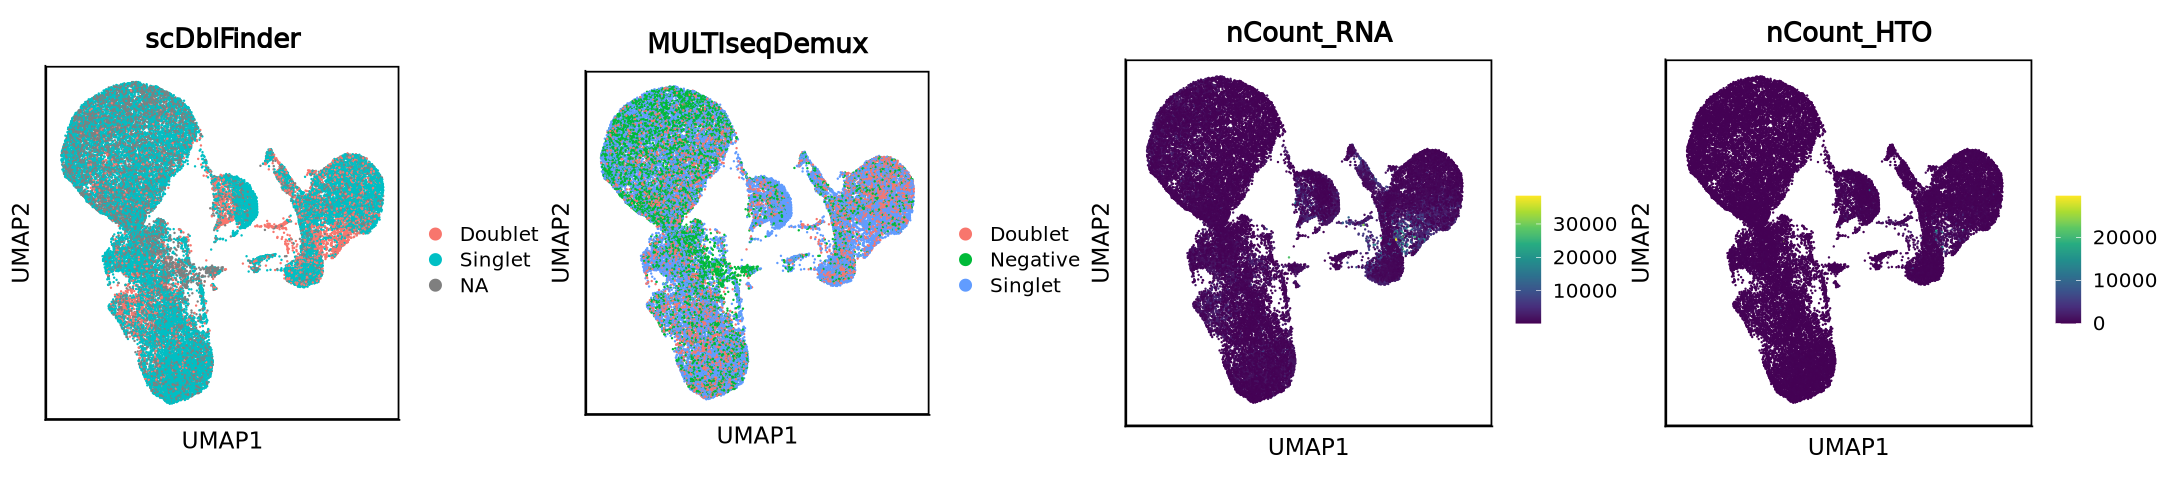

In [8]:
## visualize scDblFinder output
options(repr.plot.width=18, repr.plot.height= 4)
plist <- list(scUMAP(obj, reduction = "umap", group.by = "scDblFinder") + ggtitle("scDblFinder"))
plist[[2]] <- scUMAP(obj, reduction = "umap", group.by = "MULTI.global") + ggtitle("MULTIseqDemux")
plist[3:4] <- scFeaturePlot(obj, reduction = "umap", features = c("nCount_RNA", "nCount_HTO"), ncol = 2)
plot_grid(plotlist = plist, ncol = 4)

> Compare to the cell demultiplexing outputs, scDblFinder detects and extra 926 doublets based on transcriptomic profile.

In [9]:
## compare cell multiplexing output (truth) to scDblFinder output (call)
table(truth=obj$MULTI.global, call=obj$scDblFinder)

          call
truth      Doublet Singlet
  Doublet     1254    4060
  Negative       0       0
  Singlet     3297   20546

> scDblFinder found 7.2% doublets (1139 cells) across the 2 sequencing runs.

In [10]:
## no. / percentage of doublets
no <- length(which(obj$scDblFinder == "Doublet"))
paste0(no, " cells (", round(no*100/ncol(obj), 1), "%)")

[1] "4551 cells (12.4%)"

Visualizing quality control parameters for singlets and doublets detected by scDblFinder.

> Doublets detected have higher nFeature_RNA & nCount_RNA than singlets, reflecting the nature of true doublets.

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


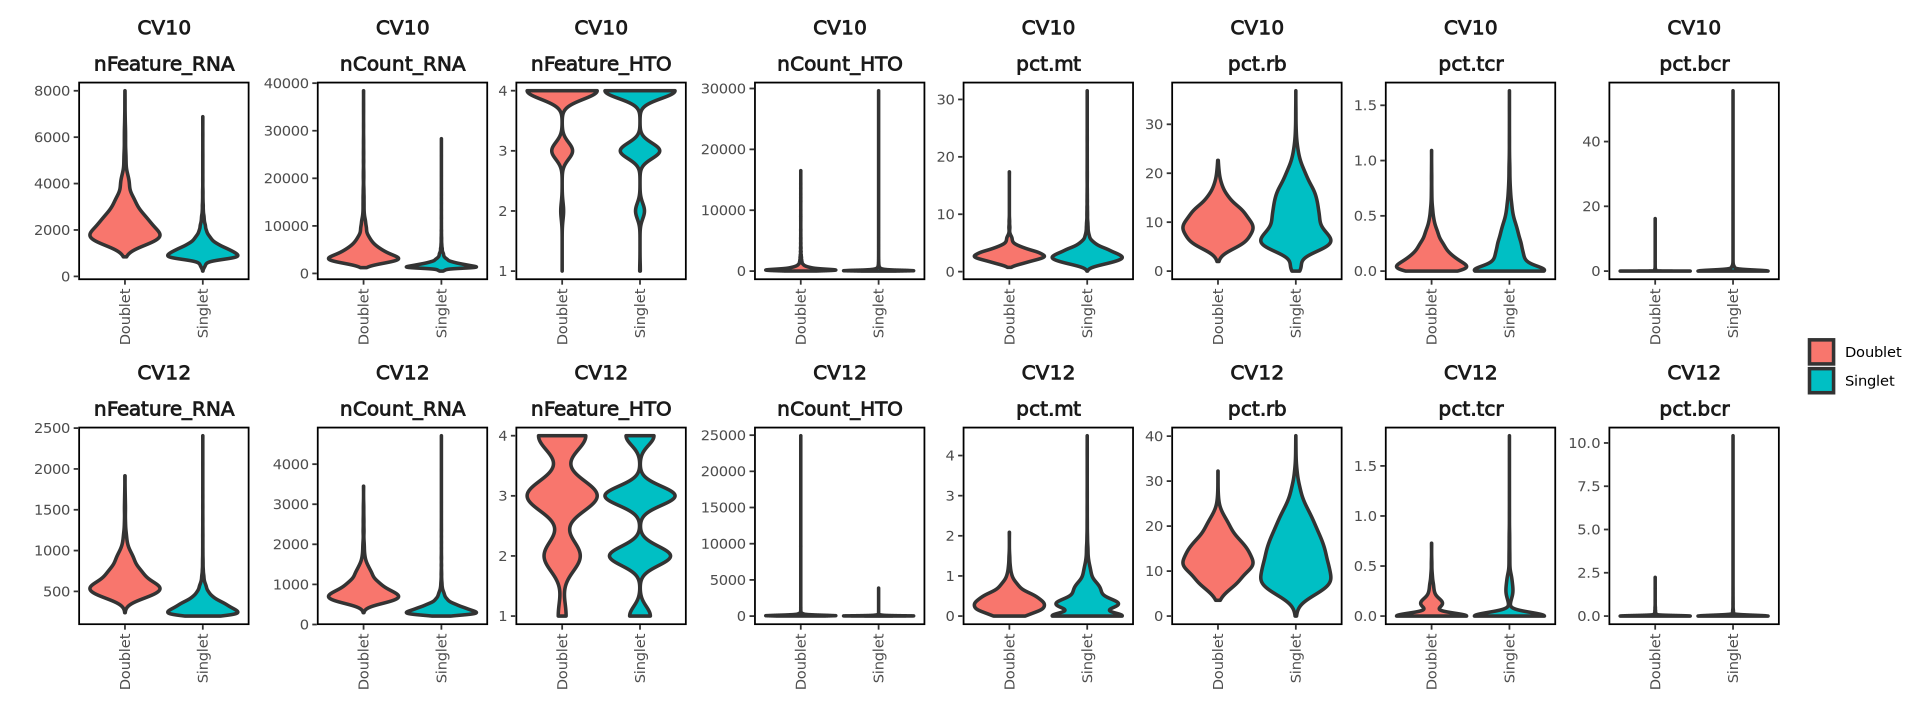

In [11]:
## Visualize qc metrics for doublets detected by scDblFinder
options(repr.plot.width=16, repr.plot.height= 6)
cols <- c("nFeature_RNA", "nCount_RNA", "nFeature_HTO", "nCount_HTO", "pct.mt", "pct.rb", "pct.tcr", "pct.bcr")
obj@meta.data %>%
    pivot_longer(cols = all_of(cols), names_to = "measures", values_to = "values") %>%
    mutate(measures = factor(measures, cols)) %>%
    filter(!is.na(scDblFinder)) %>%
    ggplot(aes(x = scDblFinder, y = values, fill = scDblFinder)) +
    geom_violin(size = 1, scale = "width", bw = "nrd0", position=position_dodge(0.75), trim = T, drop = F, adjust = 1.5) +
    facet_wrap(~samples + measures, scales = "free", ncol = 8) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    guides(fill = guide_legend(title = "")) +
    xlab("") +
    ylab("") +
    theme_border() +
    facet_aes()

## Run DoubletFinder
Continuing from scDblFinder, we will split the merged Seurat object into a list of objects by sequencing runs in order to perform the DoubletFinder pipeline. In DoubletFinder, an optional argument available is take into consideration of the cell demultiplexing outputs during doublet detection and adjust for the no. of extra heterolytic doublets detected. This can be specified in the argument \<truth\> in the wrapper function below. The wrapper function will estimate an optimal pK value that is less than 0.1 (see [https://github.com/chris-mcginnis-ucsf/DoubletFinder/issues/62](https://github.com/chris-mcginnis-ucsf/DoubletFinder/issues/62)) to perform doublet detection.

> In the run_doubletfinder() function, we specified cluster labels ("seurat_clusters"), cell demultiplexing output ("MUTLI.global"), no. of PC used (1:10) and doublet detection rate of 6.4% (dbr). 

Step 1 : Filter singlet and doublet from ground truth



NULL


Value of top pK is 0.001

Step 2 : Estimate Doublets



[1] "Creating 5858 artificial doublets..."


Loading required package: sctransform



[1] "Creating Seurat object..."
[1] "Running SCTransform..."


Running SCTransform on assay: RNA

Running SCTransform on layer: counts

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Variance stabilizing transformation of count matrix of size 22867 by 23432

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Found 17 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 22867 genes

Computing corrected count matrix for 22867 genes

Calculating gene attributes

Wall clock passed: Time difference of 1.590437 mins

Determine variable features

Centering data matrix

Getting residuals for block 1(of 5) for counts dataset

Getting residuals for block 2(of 5) for counts dataset

Getting residuals for block 3(of 5) for counts dataset

Getting residuals for block 4(of 5) for counts dataset

Getting residuals for block 5(of 5) for counts dataset

Centering data matrix

Finished calculating residu

[1] "Running PCA..."


PC_ 1 
Positive:  LYZ, S100A9, CD74, FOS, VCAN, PSAP, IFI30, S100A8, FTL, FTH1 
	   FCN1, CST3, CTSS, SAT1, NAMPT, NEAT1, SERPINA1, TYROBP, MNDA, CYBB 
	   VIM, AIF1, THBS1, CD36, HLA-DRA, TNFAIP2, PLAUR, SPI1, ZFP36, DMXL2 
Negative:  IL7R, GNLY, NKG7, PRF1, MALAT1, LEF1, IL32, RPS12, CCL5, CD247 
	   RPS3, CTSW, TCF7, ETS1, CD3E, CAMK4, IL2RG, RPL5, SKAP1, ITK 
	   LTB, CD69, INPP4B, RPL10, SYNE2, RPL3, DDX5, RPS27A, NELL2, EVL 
PC_ 2 
Positive:  CD74, MS4A1, BANK1, JCHAIN, FCRL1, HLA-DRA, AFF3, RALGPS2, HLA-DQA1, CD79A 
	   HLA-DPB1, HLA-DRB1, HLA-DPA1, LINC00926, HLA-DQB1, EEF2, FCRLA, PAX5, RPS8, EBF1 
	   NIBAN3, WDFY4, ADAM28, BACH2, COL19A1, CDK14, BLK, RUBCNL, COBLL1, SWAP70 
Negative:  PPBP, GNLY, TUBB1, NKG7, PRF1, MPIG6B, F13A1, CCL5, CAVIN2, CTSW 
	   ITGB3, CX3CR1, FCGR3A, GZMB, CD247, NRGN, THBS1, FGFBP2, MYOM2, FLNA 
	   SPON2, CST7, IL2RB, ITGA2B, VCL, KLRD1, MYL9, SPARC, GZMA, SYNE1 
PC_ 3 
Positive:  GNLY, NKG7, PRF1, S100A9, LYZ, S100A8, CX3CR1, FOS, VCAN, FCGR3A 
	

[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


Step 1 : Filter singlet and doublet from ground truth



NULL


Value of top pK is 0.001

Step 2 : Estimate Doublets



[1] "Creating 3861 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Running SCTransform..."


Running SCTransform on assay: RNA

Running SCTransform on layer: counts

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Variance stabilizing transformation of count matrix of size 15106 by 15444

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 950 genes, 5000 cells

Found 9 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 15106 genes

Computing corrected count matrix for 15106 genes

Calculating gene attributes

Wall clock passed: Time difference of 40.17004 secs

Determine variable features

Centering data matrix

Getting residuals for block 1(of 4) for counts dataset

Getting residuals for block 2(of 4) for counts dataset

Getting residuals for block 3(of 4) for counts dataset

Getting residuals for block 4(of 4) for counts dataset

Centering data matrix

Finished calculating residuals for counts

Set default assay to SCT



[1] "Running PCA..."


PC_ 1 
Positive:  HBB, TRIM58, SLC25A37, SLC25A39, ADIPOR1, UBB, FAM210B, YBX3, RNF10, MXI1 
	   GSPT1, NCOA4, RBM38, MARCH8, GYPC, RIOK3, R3HDM4, BNIP3L, CDC34, FOXO3 
	   FKBP8, UBE2H, PIP4K2A, PITHD1, RNF11, SIAH2, ARHGEF12, UBE2O, BSG, GUK1 
Negative:  RPL13, JUNB, COTL1, RPS8, MALAT1, RPL10, RPL12, RPL19, ZFP36L2, RPS2 
	   RPL9, ACTB, HLA-B, RPL32, RPL34, HLA-E, EEF1A1, HLA-A, TMSB10, SPTAN1 
	   AHNAK, RPL8, RPL13A, PFN1, PRRC2C, RPL5, H3F3B, RPL39, TMSB4X, TPT1 
PC_ 2 
Positive:  RPL13, LTB, TCF7, ZFP36L2, ETS1, MALAT1, TNFAIP3, RPL10, EEF1A1, RPS2 
	   RPS27A, TLE5, RPL3, RPS12, RPS8, RPL19, TPT1, LEPROTL1, SUN2, RPL32 
	   SARAF, IL32, RPS25, RPS18, KCNA3, RASGRP1, CD3E, RPS3A, NFATC2, RPS3 
Negative:  FTH1, CST3, COTL1, S100A9, CD74, CEBPD, LYZ, PSAP, ACTB, FCN1 
	   FTL, MAFB, EGR1, TYROBP, IFI30, TYMP, SAT1, S100A4, DUSP1, LYN 
	   MCL1, S100A6, S100A8, TNFAIP2, FOS, VIM, CTSZ, SPI1, CFD, VCAN 
PC_ 3 
Positive:  NKG7, GNLY, PRF1, EFHD2, TBX21, CTSW, SYNE1, CST7, FGFBP2, SP

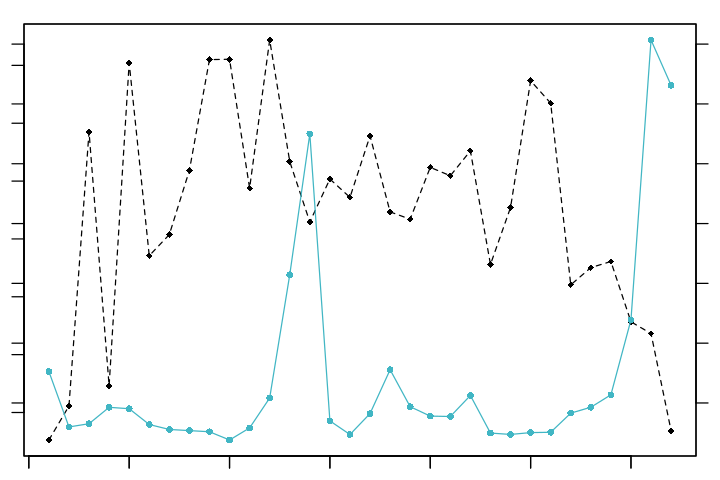

[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


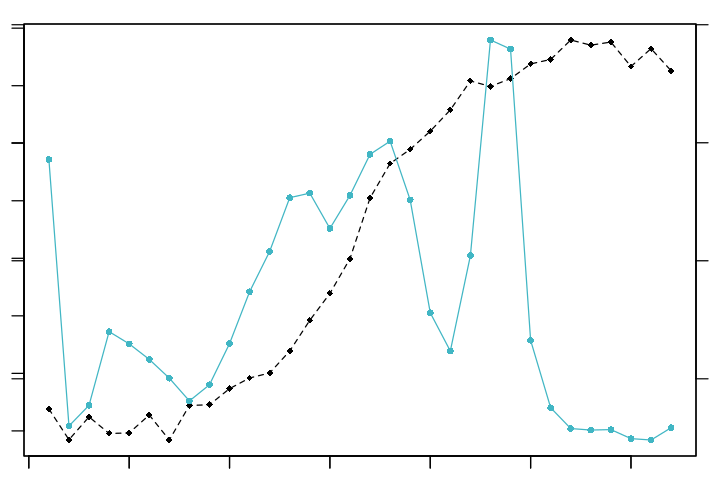

In [12]:
## split seurat object by sequencing run and run doubletfinder
options(repr.plot.width=6, repr.plot.height= 4)
obj.list <- SplitObject(obj, split.by = "samples")
for(i in seq_along(obj.list)){
    dbr <- calculate_10x_dbr(ncol(obj.list[[i]]))
    obj.list[[i]] <- run_doubletfinder(
        obj.list[[i]], 
        assay = "SCT",
        dims = 1:7, 
        truth = "MULTI.global", 
        cluster = "integrated_snn_res.0.2", 
        dbr = dbr, 
        ncores = 30)}

In [13]:
## merge seurat objects back to a single seurat object
obj <- merge(obj.list[[1]], obj.list[2:length(obj.list)], merge.dr = T)
obj <- join_layers(obj)

Merging reduction ‘pca’
Merging reduction ‘umap’


Below we visualize the outputs of DoubletFinder with MULTIseqDemux cell demultiplexing outputs and known characteristics of doublets (high nCount_RNA/HTO).

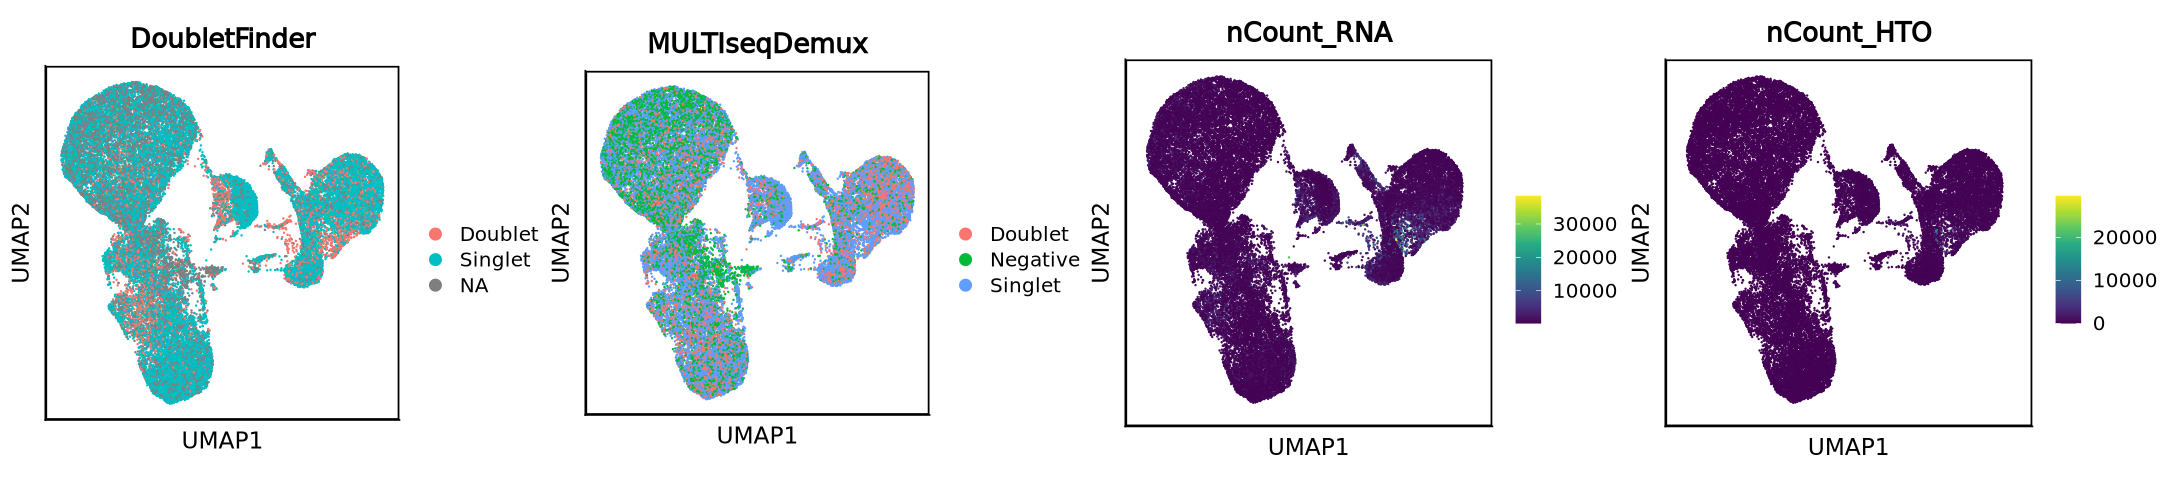

In [14]:
## Visualize doubletfinder output with multiseq demux and nCount_RNA/HTO
options(repr.plot.width=18, repr.plot.height= 4)
plist <- list(scUMAP(obj, reduction = "umap", group.by = "DoubletFinder") + ggtitle("DoubletFinder"))
plist[[2]] <- scUMAP(obj, reduction = "umap", group.by = "MULTI.global") + ggtitle("MULTIseqDemux")
plist[3:4] <- scFeaturePlot(obj, reduction = "umap", features = c("nCount_RNA", "nCount_HTO"), ncol = 2)
plot_grid(plotlist = plist, ncol = 4)

> Compare to the cell demultiplexing outputs, DoubletFinder detects and extra 745 doublets based on transcriptomic profile.

In [15]:
## Compare cell multiplexing output (truth) to doubletfinder output (call)
table(truth=obj$MULTI.global, call=obj$DoubletFinder)

          call
truth      Doublet Singlet
  Doublet     1162    4152
  Negative       0       0
  Singlet     3286   20557

> DoubletFinder found 5.6% doublets (880 cells) across the 2 sequencing runs.

In [21]:
## no. / percentage of doublets
no <- length(which(obj$DoubletFinder == "Doublet"))
paste0(no, " cells (", round(no*100/ncol(obj), 1), "%)")

[1] "4448 cells (12.1%)"

Visualizing quality control parameters for singlets and doublets detected by DoubletFinder.

> Similar to scDblFinder, doublets detected in DoubletFinder have higher nFeature_RNA & nCount_RNA than singlets, reflecting the nature of true doublets.

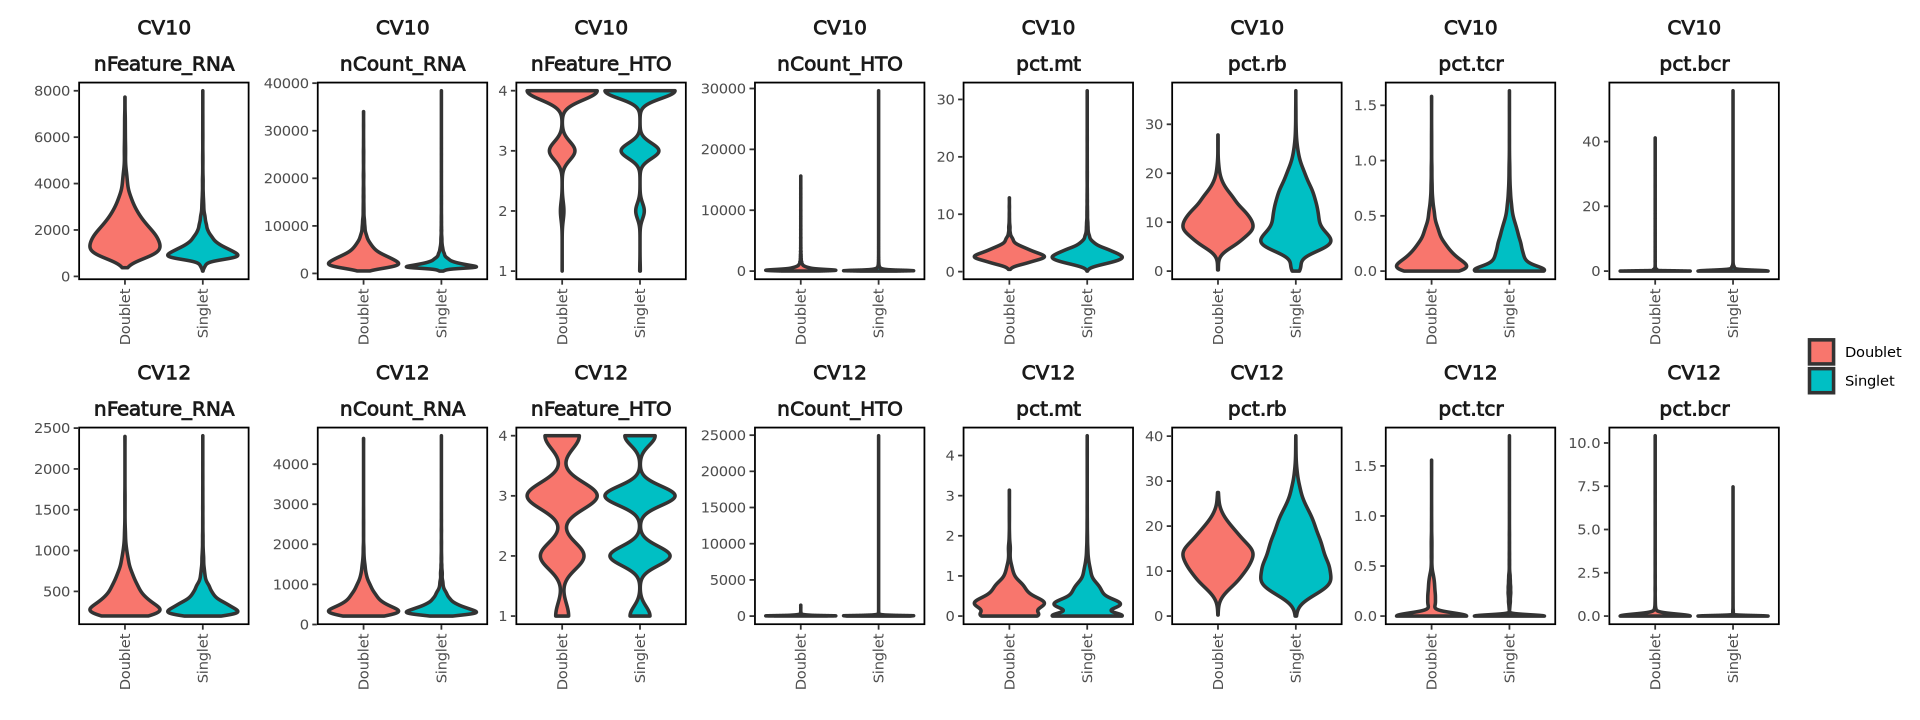

In [17]:
## Visualize qc metrics for doublets detected by DoubletFinder
options(repr.plot.width=16, repr.plot.height= 6)
cols <- c("nFeature_RNA", "nCount_RNA", "nFeature_HTO", "nCount_HTO", "pct.mt", "pct.rb", "pct.tcr", "pct.bcr")
obj@meta.data %>%
    filter(!is.na(DoubletFinder)) %>%
    pivot_longer(cols = all_of(cols), names_to = "measures", values_to = "values") %>%
    mutate(measures = factor(measures, cols)) %>%
    ggplot(aes(x = DoubletFinder, y = values, fill = DoubletFinder)) +
    geom_violin(size = 1, scale = "width", bw = "nrd0", position=position_dodge(0.75), trim = T, drop = F, adjust = 1.5) +
    facet_wrap(~samples + measures, scales = "free", ncol = 8) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    guides(fill = guide_legend(title = "")) +
    xlab("") +
    ylab("") +
    theme_border() +
    facet_aes()

## T/B-cell Doublets
T/B-cells represent the most abundant of immune cell populations and have a high chance to be sequenced together as doublets. T and B-cells can be characterized by TCR-VDJ and BCR-VDJ gene expression respectively, the TCR/BCR expressions are mutually exclusive. Therefore T/B-cell doublets can be manually identified and removed if the TCR/BCR fraction is high.

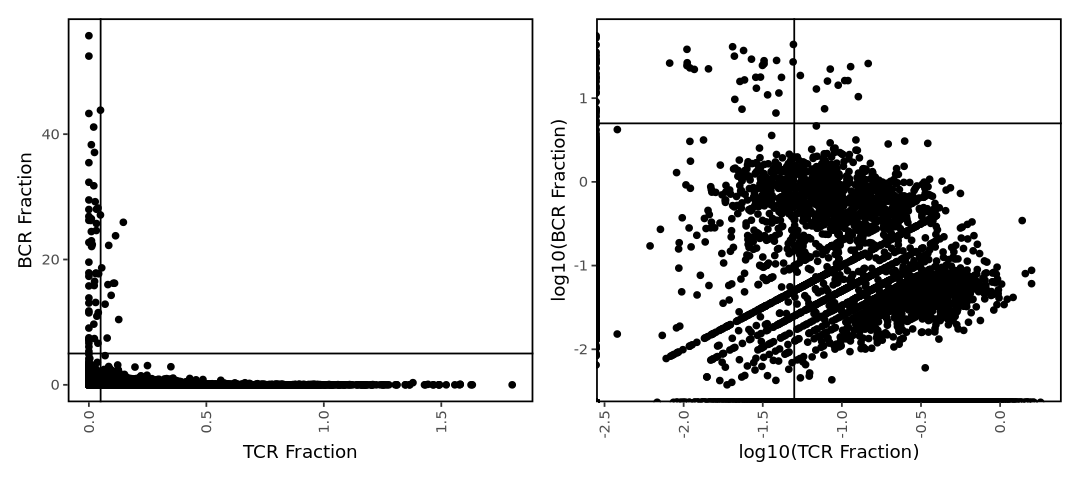

In [18]:
## visualize BCR/TCR read fractions
options(repr.plot.width=9, repr.plot.height= 4)
p1 <- obj@meta.data %>%
    ggplot(aes(x = pct.tcr, y = pct.bcr)) +
    geom_point() +
    theme_border() +
    geom_hline(yintercept = 5) +
    geom_vline(xintercept = 0.05) +
    xlab("TCR Fraction") +
    ylab("BCR Fraction")
p2 <- obj@meta.data %>%
    ggplot(aes(x = log10(pct.tcr), y = log10(pct.bcr))) +
    geom_point() +
    theme_border() +
    geom_hline(yintercept = log10(5)) +
    geom_vline(xintercept = log10(0.05)) +
    xlab("log10(TCR Fraction)") +
    ylab("log10(BCR Fraction)")
p1 + p2

> Judging from the plot above, we have called T/B-cell doublets if TCR fraction is > 0.05% and BCR > 5%

In [19]:
## manually set TCR/BCR fraction threshold
obj@meta.data <- obj@meta.data %>%
    mutate(TB_Doublet = ifelse(pct.tcr > 0.05 & pct.bcr > 5, "Doublet", "Singlet"))

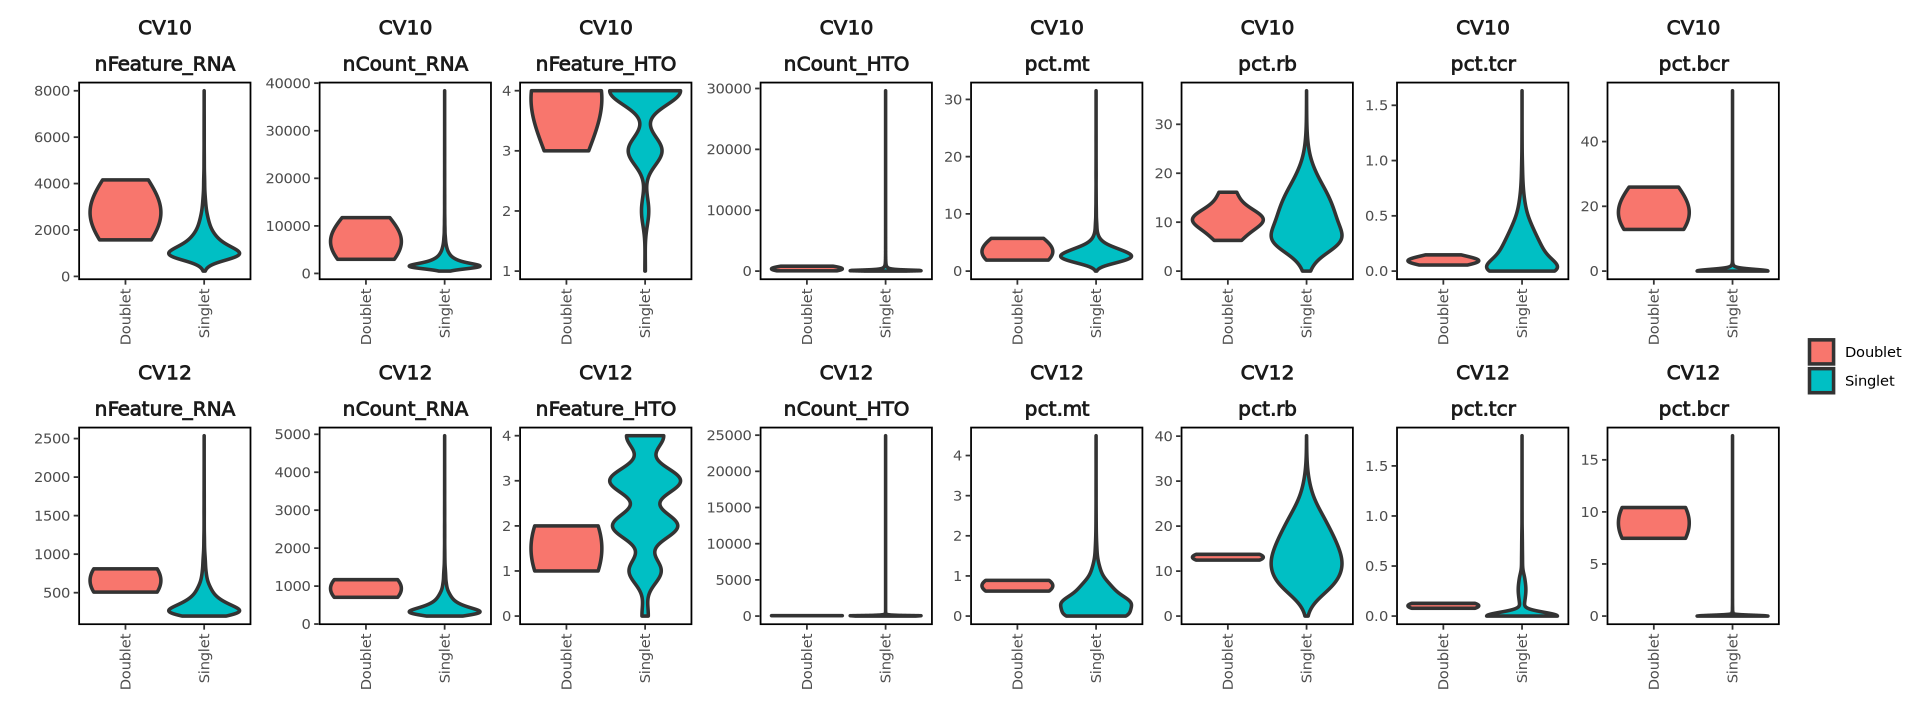

In [20]:
## Visualize qc metrics for TB doublets
options(repr.plot.width=16, repr.plot.height= 6)
cols <- c("nFeature_RNA", "nCount_RNA", "nFeature_HTO", "nCount_HTO", "pct.mt", "pct.rb", "pct.tcr", "pct.bcr")
obj@meta.data %>%
    pivot_longer(cols = all_of(cols), names_to = "measures", values_to = "values") %>%
    mutate(measures = factor(measures, cols)) %>%
    ggplot(aes(x = TB_Doublet, y = values, fill = TB_Doublet)) +
    geom_violin(size = 1, scale = "width", bw = "nrd0", position=position_dodge(0.75), trim = T, drop = F, adjust = 3) +
    facet_wrap(~samples + measures, scales = "free", ncol = 8) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    guides(fill = guide_legend(title = "")) +
    xlab("") +
    ylab("") +
    theme_border() +
    facet_aes()

## Evaluating Outputs
scDblFinder and DoubletFinder are both able to predict heterolytic doublets with characteristics reflective of true doublet nature. From the UMAP projections below, you can see the outputs from the 2 algorithms are highly consistent with each other.

> The small cluster of cells circled on the UMAP below are highly likely to be real doublets given the cell number, which is only detected by DoubletFinder and not scDblFinder. Therefore, for the following chapters, we will continue using outputs from DoubletFinder.

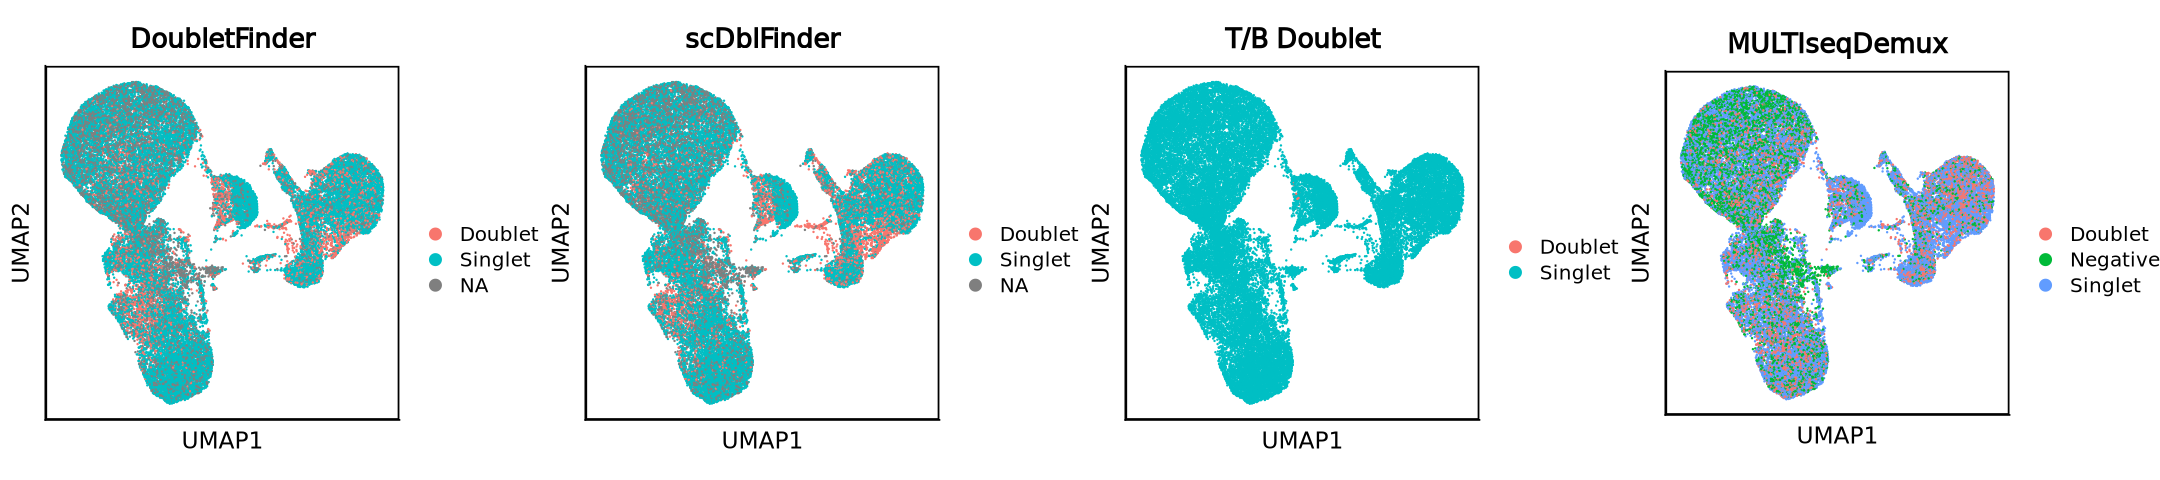

In [25]:
options(repr.plot.width=18, repr.plot.height= 4)
r = 1
xc = 5.5
yc = 7.5
plist <- list(scUMAP(obj, reduction = "umap", group.by = "DoubletFinder") + 
    ggtitle("DoubletFinder") #+
    #annotate("path",
    #    x=xc+r*cos(seq(0,2*pi,length.out=100)),
    #    y=yc+r*sin(seq(0,2*pi,length.out=100)),
    #    linetype = "dashed")
    )
plist[[2]] <- scUMAP(obj, reduction = "umap", group.by = "scDblFinder") + 
    ggtitle("scDblFinder") #+
    #annotate("path",
    #    x=xc+r*cos(seq(0,2*pi,length.out=100)),
    #    y=yc+r*sin(seq(0,2*pi,length.out=100)),
    #    linetype = "dashed")
plist[[3]] <- scUMAP(obj, reduction = "umap", group.by = "TB_Doublet") + ggtitle("T/B Doublet")
plist[[4]] <- scUMAP(obj, reduction = "umap", group.by = "MULTI.global") + ggtitle("MULTIseqDemux")
plot_grid(plotlist = plist, ncol = 4)

~1/3 of the doublets detected by either algorithms are consistent.

In [22]:
## Compare outputs from scDblFinder and DoubletFinder
table(scDblFinder=obj$scDblFinder, DoubletFinder=obj$DoubletFinder)

           DoubletFinder
scDblFinder Doublet Singlet
    Doublet    2355    2196
    Singlet    2093   22513

## Checking Immune Populations

Step 1 : Formatting gene list



Step 2 : Summarizing gene expression

Warning message:
“The following requested variables were not found: LYZ2”
Step 3 : Annotating expression significance

Step 4 : Construct final expression dataframe

Step 5 : Plotting gene expression



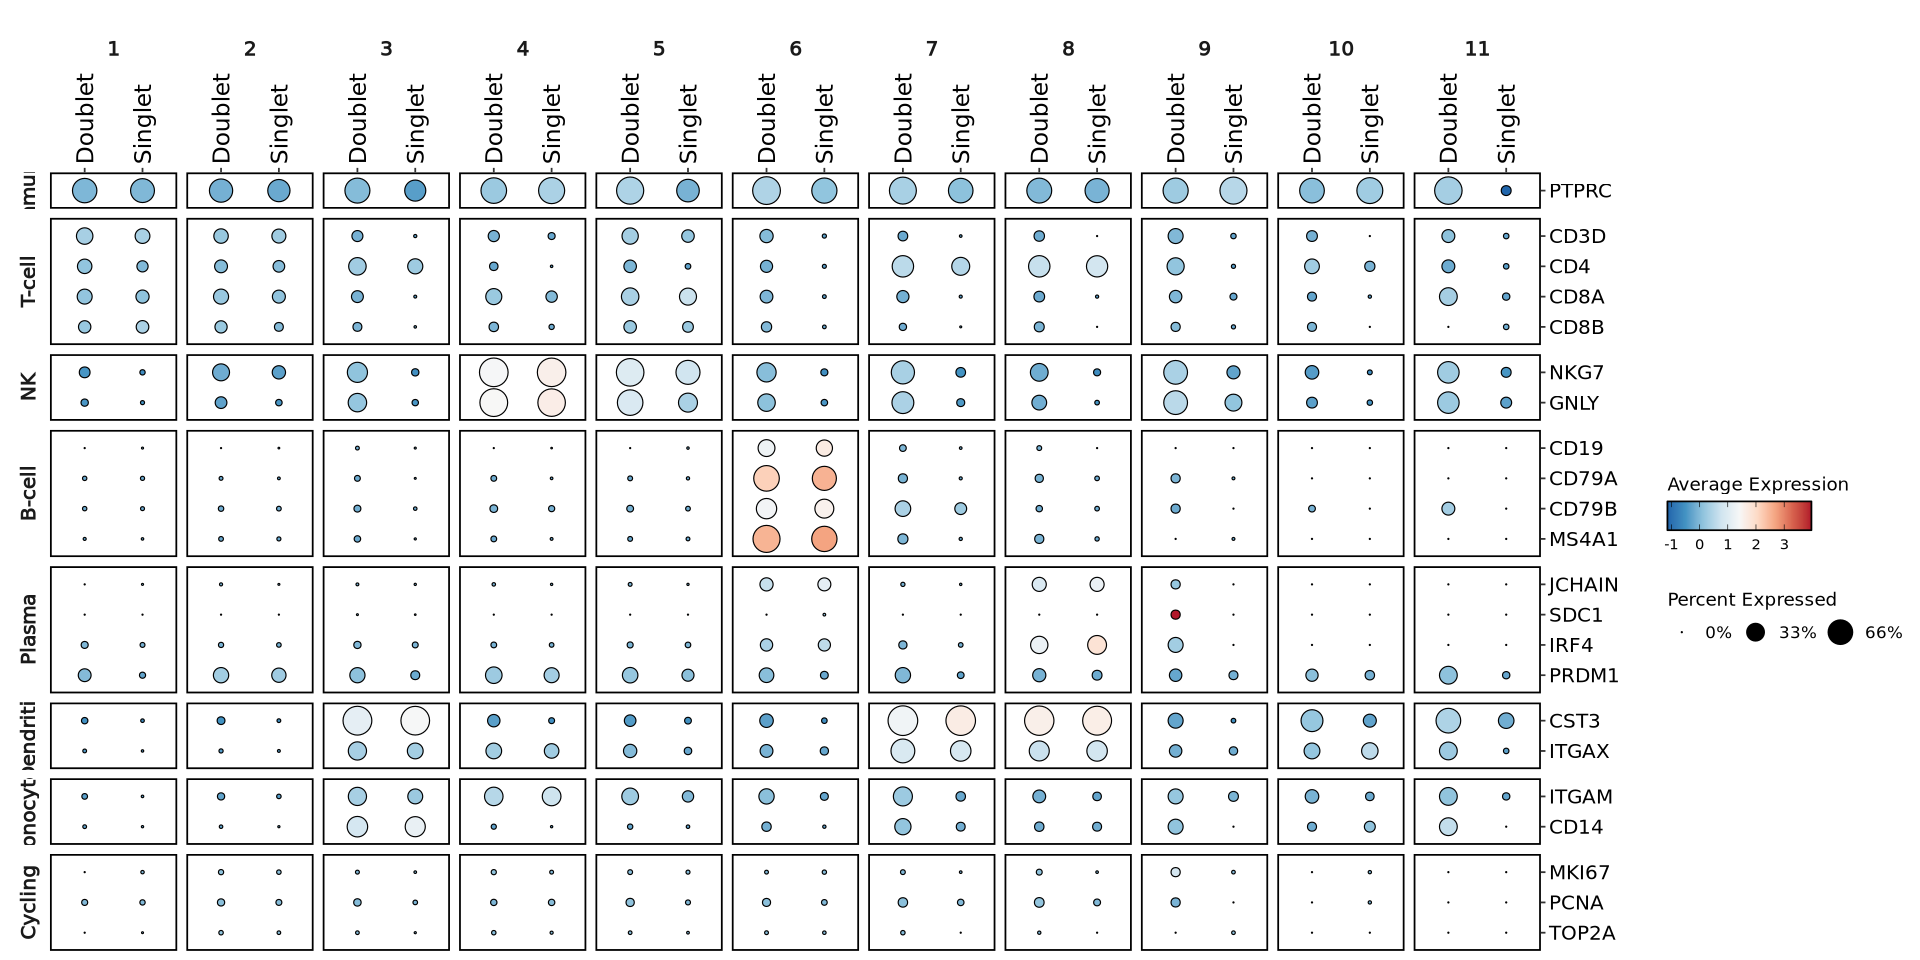

In [12]:
immune.hs <- list(
    Immune = c("PTPRC"),
    `T-cell` =  c("CD3D", "CD4", "CD8A", "CD8B"),
    NK = c("NKG7", "GNLY"),
    `B-cell` = c("CD19", "CD79A", "CD79B", "MS4A1"),
    Plasma = c("JCHAIN", "SDC1", "IRF4", "PRDM1"),
    Dendritic = c("CST3", "ITGAX"),
    Monocytes = c("LYZ2", "ITGAM", "CD14"),
    Cycling = c("MKI67", "PCNA", "TOP2A"))

options(repr.plot.width=16, repr.plot.height=8)
scDotPlot(subset(obj, subset = MULTI.global == "Negative", invert = T), features = immune.hs, group.by = "scDblFinder", split.by = "leiden_0.2", assay = "RNA")

Step 1 : Formatting gene list

Step 2 : Summarizing gene expression

Warning message:
“The following requested variables were not found: LYZ2”
Step 3 : Annotating expression significance

Step 4 : Construct final expression dataframe

Step 5 : Plotting gene expression



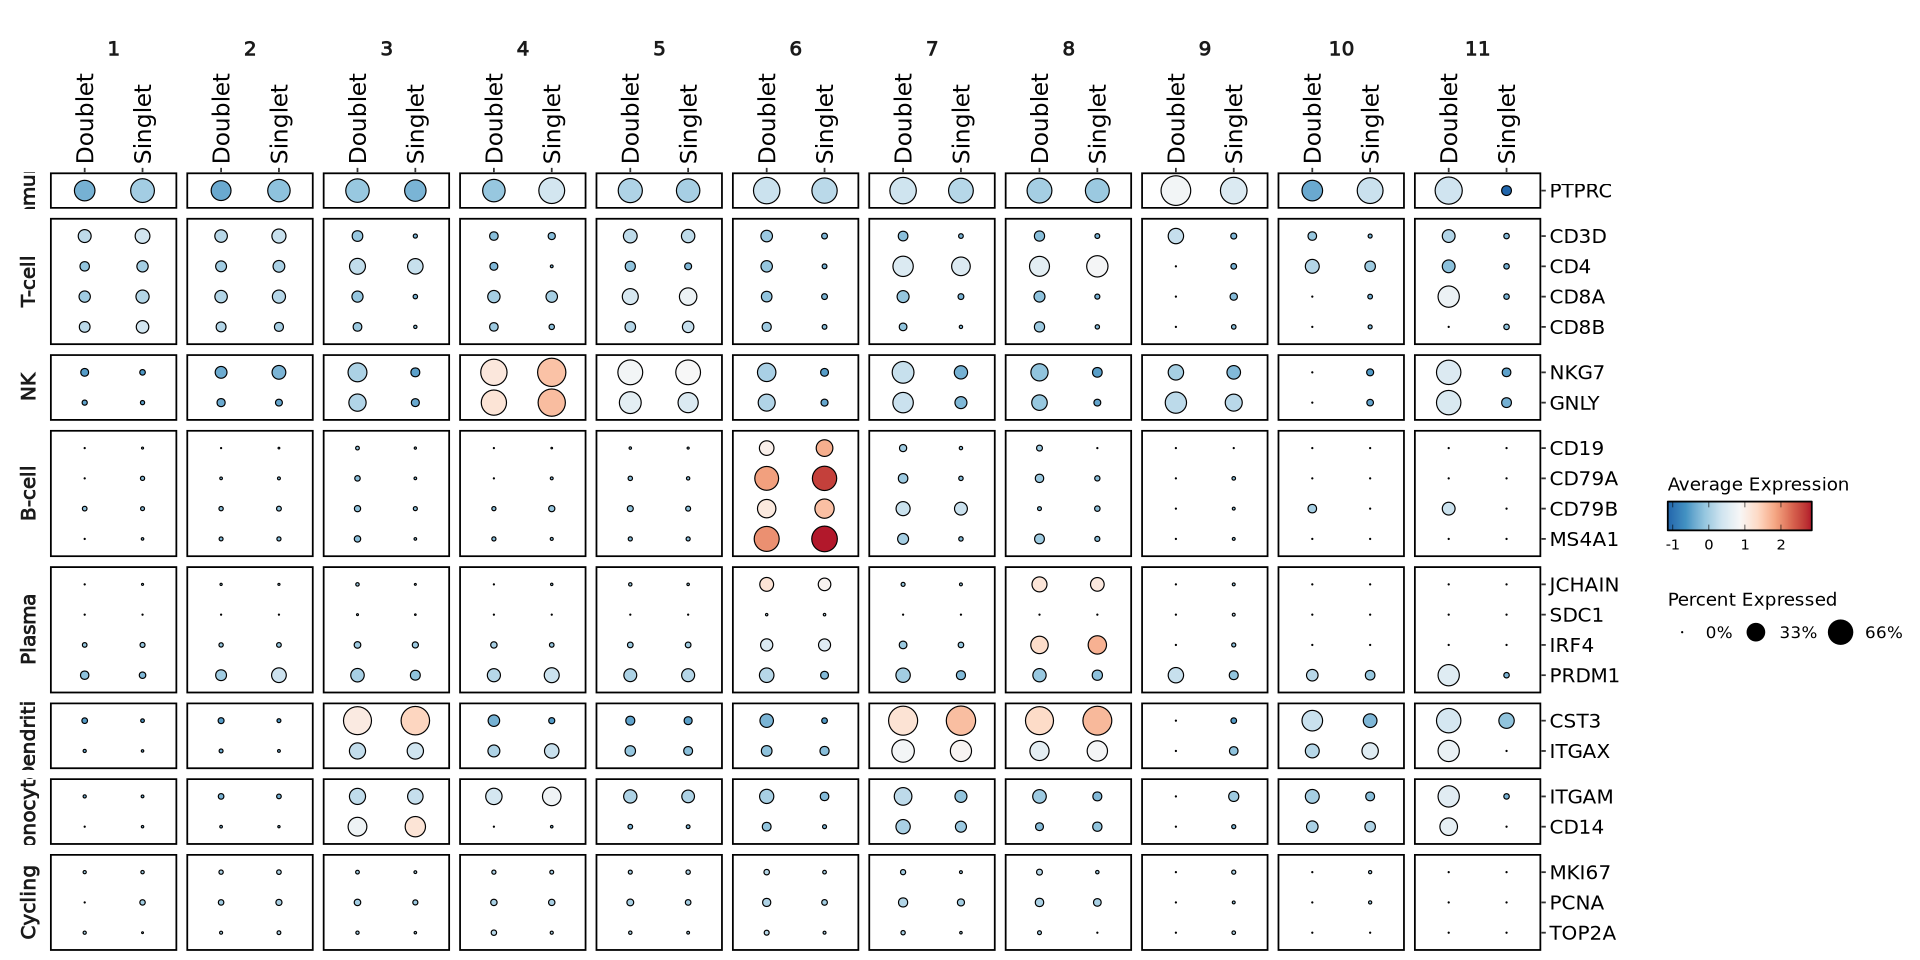

In [13]:
options(repr.plot.width=16, repr.plot.height=8)
scDotPlot(subset(obj, subset = MULTI.global == "Negative", invert = T), features = immune.hs, group.by = "DoubletFinder", split.by = "leiden_0.2", assay = "RNA")

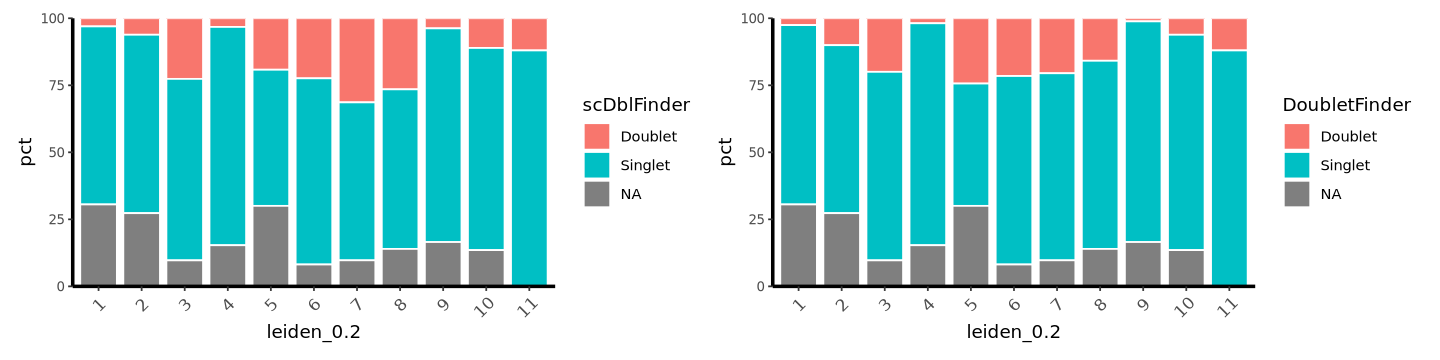

In [6]:
options(repr.plot.width=12, repr.plot.height=3)
p1 <- obj@meta.data %>%
    group_by(leiden_0.2, scDblFinder) %>%
    summarize(count = n()) %>%
    group_by(leiden_0.2) %>%
    mutate(pct = count*100/sum(count)) %>%
    ggplot(aes(x = leiden_0.2, y = pct, fill = scDblFinder)) +
    geom_col(width = 0.85, col = "white") +
    theme_line() +
    theme_text()
p2 <- obj@meta.data %>%
    group_by(leiden_0.2, DoubletFinder) %>%
    summarize(count = n()) %>%
    group_by(leiden_0.2) %>%
    mutate(pct = count*100/sum(count)) %>%
    ggplot(aes(x = leiden_0.2, y = pct, fill = DoubletFinder)) +
    geom_col(width = 0.85, col = "white") +
    theme_line() +
    theme_text()

p1 + p2

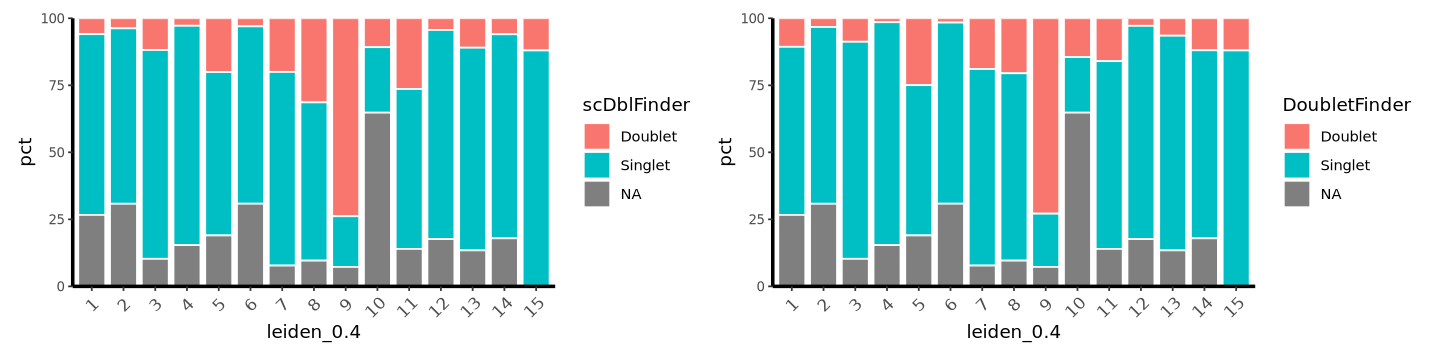

In [7]:
options(repr.plot.width=12, repr.plot.height=3)
p1 <- obj@meta.data %>%
    group_by(leiden_0.4, scDblFinder) %>%
    summarize(count = n()) %>%
    group_by(leiden_0.4) %>%
    mutate(pct = count*100/sum(count)) %>%
    ggplot(aes(x = leiden_0.4, y = pct, fill = scDblFinder)) +
    geom_col(width = 0.85, col = "white") +
    theme_line() +
    theme_text()
p2 <- obj@meta.data %>%
    group_by(leiden_0.4, DoubletFinder) %>%
    summarize(count = n()) %>%
    group_by(leiden_0.4) %>%
    mutate(pct = count*100/sum(count)) %>%
    ggplot(aes(x = leiden_0.4, y = pct, fill = DoubletFinder)) +
    geom_col(width = 0.85, col = "white") +
    theme_line() +
    theme_text()
p1 + p2

In [ ]:
qsave(obj, file = "seurat/1_processing/1.7_GSE247917_doublets.qs")

## Rerun Unsupervised Clustering

In [3]:
obj <- qread("seurat/1_processing/1.7_GSE247917_doublets.qs")

In [4]:
obj <- join_layers(obj)
obj <- subset(obj, subset = finalqc == "Pass")
obj <- subset(obj, subset = DoubletFinder == "Singlet")
obj <- qc_before_recluster(obj)

Warning message:
“Different cells and/or features from existing assay RNA”


In [5]:
# select assay and nfeatures to use
assay <- "RNA"
nfeatures = 2000

Finding variable features for layer counts



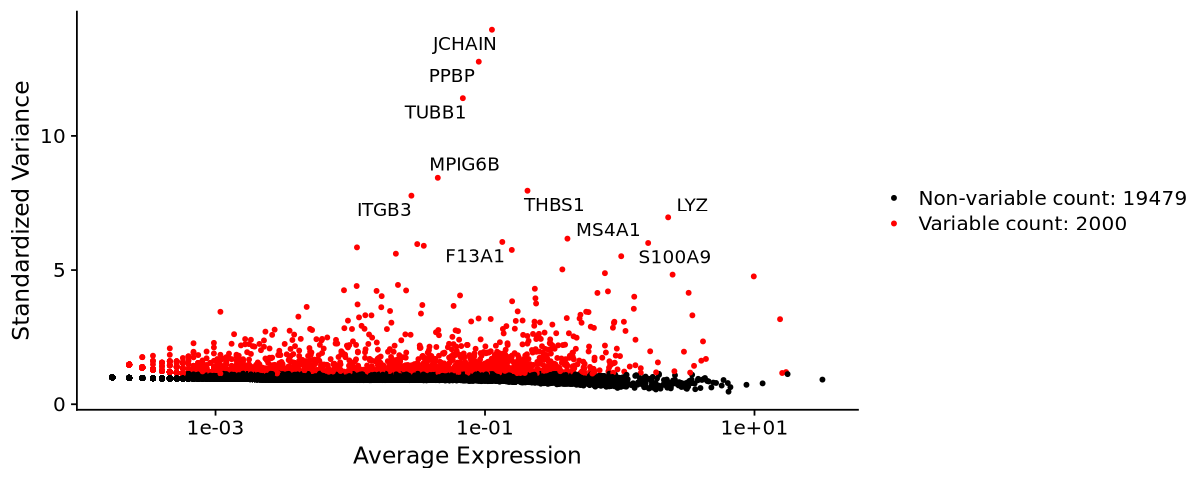

In [6]:
# show top 2000 variable features
options(repr.plot.width=10, repr.plot.height=4)
DefaultAssay(obj) <- assay
obj <- FindVariableFeatures(obj, nfeatures = nfeatures)
VariableFeaturePlot(obj) +
    geom_text_repel(data = VariableFeaturePlot(obj)$data %>% 
        rownames_to_column("gene") %>%
        slice_max(n = 10, order_by = variance.standardized) %>%
        as.data.frame(), aes(label = gene))

### Batch Correction
We will use Seurat V4 RPCA integration method to correct for batch effects between CV10 and CV12. See next section [@chapter-integration] on selecting and evaluating different integration methods.

In [8]:
# run wrapper function to perform seurat RPCA integraton
obj <- integrate_v4(obj, split.by = "samples", assay = assay, nfeatures = nfeatures, vars.to.regress = c("S.Score", "G2M.Score"), method = "rpca", k.weight = 100)

Running SCTransform on assay: RNA

Running SCTransform on layer: counts

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Variance stabilizing transformation of count matrix of size 19872 by 12297

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Found 319 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 19872 genes

Computing corrected count matrix for 19872 genes

Calculating gene attributes

Wall clock passed: Time difference of 47.16021 secs

Determine variable features

Regressing out S.Score, G2M.Score

Centering data matrix

Getting residuals for block 1(of 3) for counts dataset

Getting residuals for block 2(of 3) for counts dataset

Getting residuals for block 3(of 3) for counts dataset

Centering data matrix

Finished calculating residuals for counts

Warning message:
“Different cells and/or features from exist

  |======================================================================| 100%


sct.model: counts on 2000 cells: CV10_AGTCTTTGTGCAGTAG-1 .. CV10_CCCTCCTGTCCTGCTT-1

Setting min_variance to:  0.04

Calculating residuals of type pearson for 9975 genes



  |======================================================================| 100%


sct.model: counts on 2000 cells: CV10_CCCTCCTGTGATGCCC-1 .. CV10_CTGATCCTCACATACG-1

Setting min_variance to:  0.04

Calculating residuals of type pearson for 9975 genes



  |======================================================================| 100%


sct.model: counts on 2000 cells: CV10_CTGATCCTCAGTACGT-1 .. CV10_GGAACTTCATGCTAGT-1

Setting min_variance to:  0.04

Calculating residuals of type pearson for 9975 genes



  |======================================================================| 100%


sct.model: counts on 2000 cells: CV10_GGAACTTGTAAGGGAA-1 .. CV10_TAGGCATAGCCACTAT-1

Setting min_variance to:  0.04

Calculating residuals of type pearson for 9975 genes



  |======================================================================| 100%


sct.model: counts on 2000 cells: CV10_TAGGCATAGGCGACAT-1 .. CV10_TTGACTTAGTGTCCCG-1

Setting min_variance to:  0.04

Calculating residuals of type pearson for 9975 genes



  |======================================================================| 100%


sct.model: counts on 297 cells: CV10_TTGACTTAGTGTTGAA-1 .. CV10_TTTGTCATCTTTAGGG-1

Setting min_variance to:  0.04

Calculating residuals of type pearson for 9975 genes



  |======================================================================| 100%
[1] 1


Warning message:
“Different cells and/or features from existing assay SCT”
sct.model: counts on 2000 cells: CV12_AAACCTGCAAGGTTTC-1 .. CV12_CGCGGTACACCGGAAA-1

Setting min_variance to:  0.04

Calculating residuals of type pearson for 9975 genes



  |======================================================================| 100%


sct.model: counts on 2000 cells: CV12_CGCGGTACACTACAGT-1 .. CV12_TAAGCGTTCACTTACT-1

Setting min_variance to:  0.04

Calculating residuals of type pearson for 9975 genes



  |======================================================================| 100%


sct.model: counts on 1184 cells: CV12_TAAGCGTTCCGTACAA-1 .. CV12_TTTGTCATCTGATACG-1

Setting min_variance to:  0.04

Calculating residuals of type pearson for 9975 genes



  |======================================================================| 100%
[1] 2


Warning message:
“Different cells and/or features from existing assay SCT”
Merging dataset 2 into 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
“Assay integrated changing from SCTAssay to Assay”
Warning message:
“Different cells and/or features from existing assay integrated”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.6 GiB”
Warning message:
“Assay integrated changing from Assay to SCTAssay”
Warning message:
“Different cells and/or features from existing assay SCT”


### Principal Component Analysis

PC_ 1 
Positive:  LYZ, S100A9, FTL, IFI30, FOS, PSAP, CD74, S100A8, VCAN, FTH1 
	   FCN1, CST3, SAT1, CTSS, NAMPT, TYROBP, SERPINA1, CYBB, NEAT1, MNDA 
	   AIF1, TNFAIP2, SPI1, VIM, PLXDC2, CD36, CD68, S100A6, LRMDA, HLA-DRA 
Negative:  MALAT1, IL7R, RPS12, NKG7, GNLY, IL32, CD3E, PRF1, LEF1, RPL5 
	   RPS3, LTB, RPL10, CD247, CCL5, ETS1, TCF7, CAMK4, EEF1A1, RPL3 
	   RPS27A, DDX5, INPP4B, RPL13, IL2RG, CTSW, SKAP1, ITK, SELL, RPSA 
PC_ 2 
Positive:  GNLY, NKG7, PRF1, CCL5, CX3CR1, CTSW, GZMB, FCGR3A, FGFBP2, CST7 
	   SPON2, CD247, KLRD1, IL2RB, SYNE1, GZMA, KLRF1, GZMH, ITGB2, TGFBR3 
	   AOAH, FLNA, HLA-B, ADGRG1, PRSS23, HLA-C, ACTN4, S1PR5, SH2D1B, PFN1 
Negative:  RPS12, RPLP1, RPS8, RPL10, RPL13, TPT1, EEF2, CD74, RPL32, AL138963.4 
	   IL7R, EEF1A1, RPL18A, RPS18, RPL4, RPL11, RPS14, LTB, RPL30, RPS3A 
	   LEF1, RPS23, RPL5, RPL19, RPLP0, RPS13, RPS27A, RPS15A, SELL, MS4A1 
PC_ 3 
Positive:  S100A9, IL7R, S100A8, LYZ, FOS, VCAN, LEF1, TPT1, TCF7, CAMK4 
	   INPP4B, CD3E, FYB1,

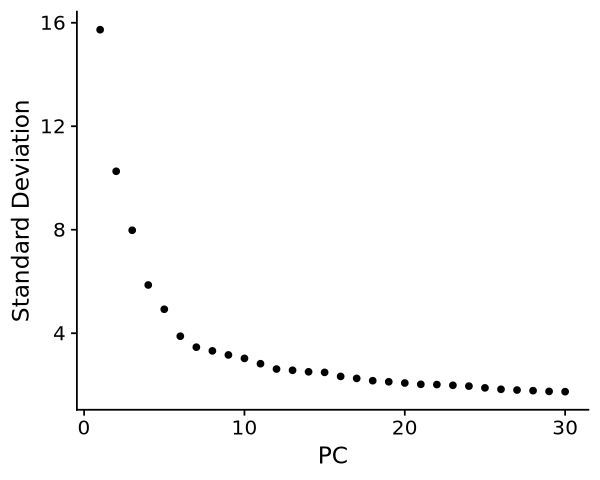

In [9]:
options(repr.plot.width=5, repr.plot.height=4)
obj <- RunPCA(obj)
ElbowPlot(obj, ndims = 30, reduction = "pca")

### UMAP Projection

In [ ]:
obj <- RunUMAP(obj, dims = 1:7, reduction = "pca", reduction.name = "umap", assay = "integrated", verbose = FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’



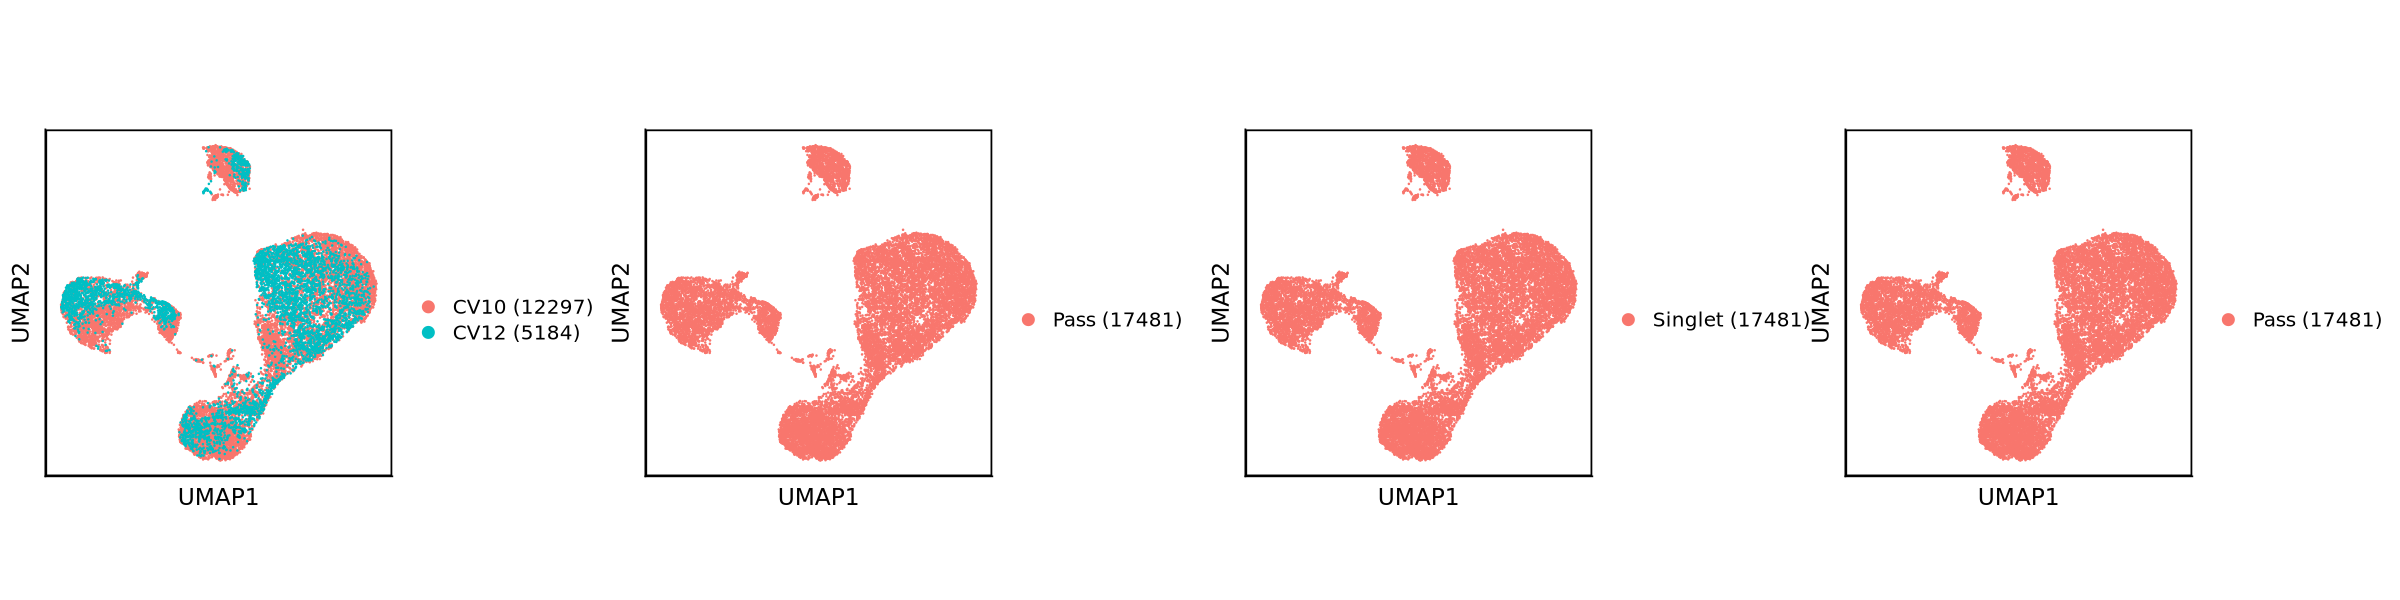

In [11]:
options(repr.plot.width=20, repr.plot.height=5)
p1 <- scUMAP(obj, reduction = "umap", group.by = "samples", count = T)
p2 <- scUMAP(obj, reduction = "umap", group.by = "softqc", count = T)
p3 <- scUMAP(obj, reduction = "umap", group.by = "MULTI.global", count = T)
p4 <- scUMAP(obj, reduction = "umap", group.by = "finalqc", count = T)
plot_grid(p1, p2, p3, p4, ncol = 4, align = "hv")

### Find Clusters

In [13]:
obj <- FindNeighbors(obj, reduction = "pca", dims = 1:7, verbose = F)

In [33]:
use_condaenv("/camp/home/hungm/.conda/envs/r-reticulate")
obj <- FindClusters(obj, resolution = seq(0.1, 1, 0.1), algorithm = 4, verbose = F)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”
Warning message in paste("reticulate", module, "load", sep = "::"):
“NAs introduced by coercion to integer range”
Warning message in paste("reticulate", module, "load", sep = "::"):
“NAs introduced by coercion to integer range”
Warning message in paste("reticulate", module, "load", sep = "::"):
“NAs introduced by coercion to integer range”
Warning message in paste("reticulate", module, "load", sep = "::"):
“NAs introduced by coercion to integer range”
Warning message in paste("reticulate", module, "load", sep = "::"):
“NAs introduced by coercion to integer range”
Warning message in paste("reticulate", module, "load", sep = "::"):
“NAs introduced by coercion to integer range”
Warning message in paste("reticulate", module, "load", sep = "::"):
“NAs introduced by coercion to integer range”
Warning message in paste("reticulate", module, "load", sep = "::"):
“NAs introduced by coercion to intege

In [35]:
cols <- paste0("integrated_snn_res.", seq(0.1, 1, 0.1))
for(i in cols){
    obj@meta.data[[gsub("integrated_snn_res.", "leiden_", i)]] <- obj@meta.data[[i]]
    obj@meta.data[[i]] <- NULL}
clustree <- clustree(obj@meta.data, prefix = paste0("leiden_"))

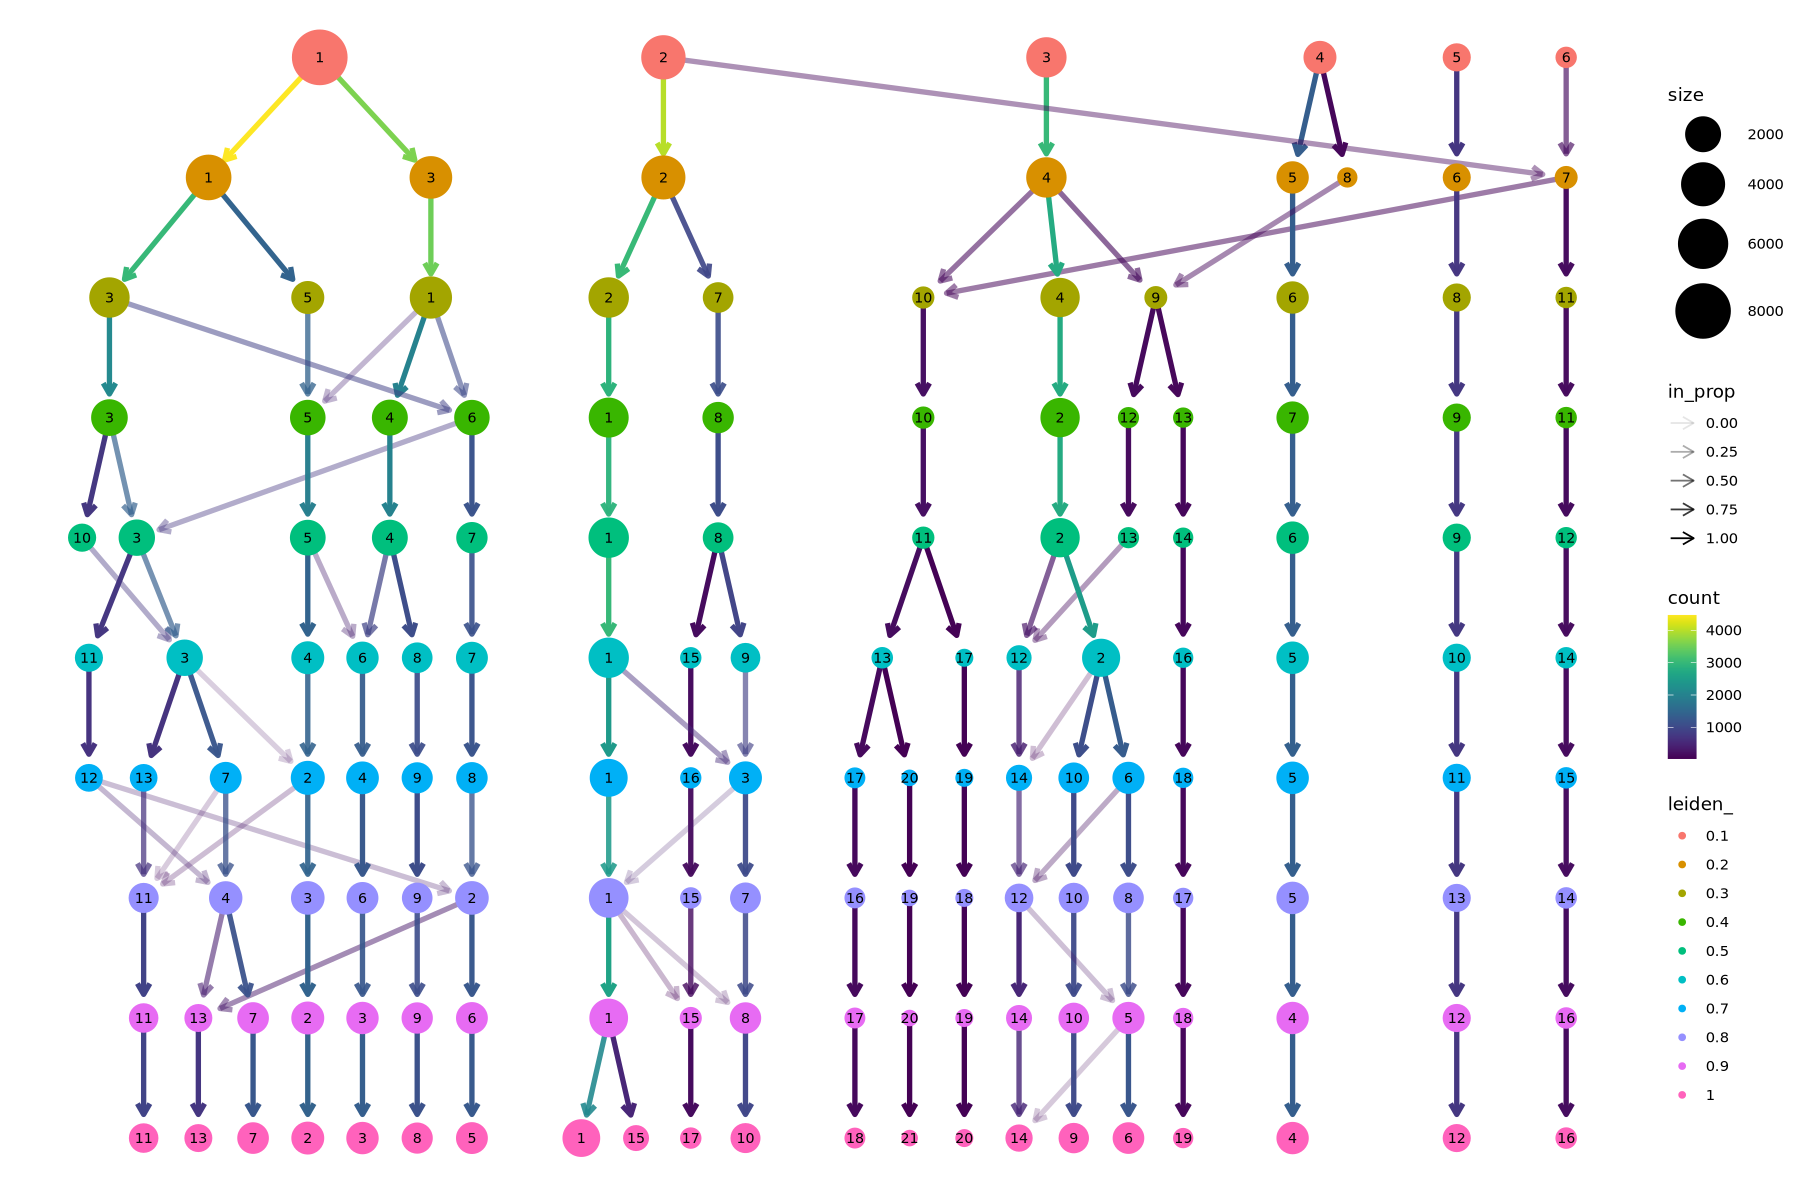

In [36]:
options(repr.plot.width=15, repr.plot.height=10)
print(clustree)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


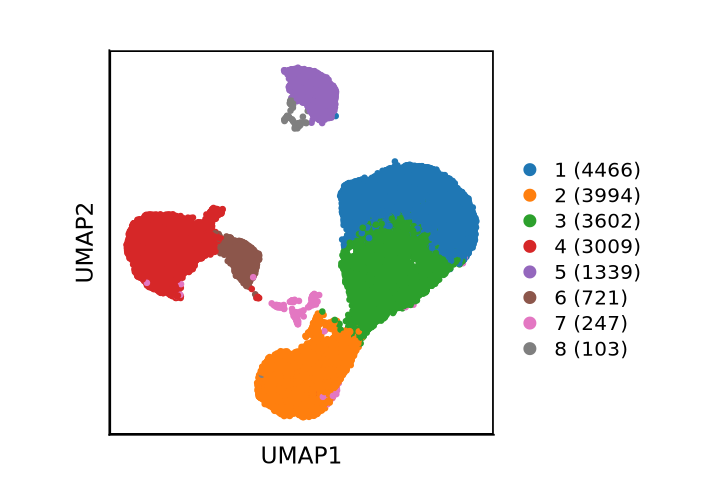

In [37]:
options(repr.plot.width=6, repr.plot.height=4)
scUMAP(obj, reduction = "umap", group.by = "leiden_0.2", count = T, pt.size = 1.2, cols = palette_list[["vega_10"]])

## Session Info {.unnumbered}

In [38]:
qsave(obj, file = "seurat/1_processing/1.7_GSE247917_doublet_filtered.qs")

In [39]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Rocky Linux 8.7 (Green Obsidian)

Matrix products: default
BLAS/LAPACK: /nemo/lab/caladod/working/Matthew/.conda/envs/seurat5/lib/libopenblasp-r0.3.23.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/London
tzcode source: system (glibc)

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] reticulate_1.34.0           clustree_0.5.0             
 [3] ggraph_2.1.0                scUnify_0.0.0.9000         
 [5] ComplexHeatmap_2.16.0       DoubletFinder